In [7]:
from model.med_sam import prompter_network
from utils.Transform import get_single_box
import torch
import os
join = os.path.join
from monai.transforms import (Compose, ToTensord, LoadImaged, EnsureChannelFirstd, 
                              EnsureTyped, RepeatChanneld, ScaleIntensityRanged)
from segment_anything import sam_model_registry
from monai.data.dataset import CacheDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from utils.Transform import box_generater

checkpoint = '/data3/home/lishengyong/code/MedSAM/saved/model/0818_98/model_best.pth'
root = "/data3/home/lishengyong/data/ssc_0802/new821"
sam_model = sam_model_registry["vit_b"]()
sam_model.eval()
info = torch.load(checkpoint)
my_dic_keys = list(info['state_dict'].keys())
for key in my_dic_keys:
    info['state_dict'][key.replace("module.", "")] = info['state_dict'].pop(key)
sam_model.load_state_dict(info['state_dict'])

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=0.5)) 


sam_prompt = prompter_network(sam_model, True)
test_transform = Compose([
                    LoadImaged(keys=["image", "mask"]), 
                    EnsureChannelFirstd(keys=["image", "mask"]),
                    EnsureTyped(keys=["image"], dtype=torch.float32),
                    EnsureTyped(keys=["mask"], dtype=torch.long),
                    ScaleIntensityRanged("image", -1250, 500, 0, 1, True),
                    get_single_box(),
                    RepeatChanneld("image", 3),
                    ToTensord(keys=["image"], dtype=torch.float32)
                ])



/data3/home/lishengyong/anaconda3/envs/sam/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [8]:


casename = "0.nii.gz"
img_path = join(root, "images", casename)
mask_path = join(root, "masks", casename)
test_files = [{"image": img_path, "mask": mask_path}]
val_dataset = CacheDataset(test_files, test_transform, cache_rate=0, num_workers=4)
imgs = val_dataset[0]["image"].unsqueeze(0)
img_2024 = F.interpolate(
            imgs,
            size=(1024, 1024),
            mode="bilinear",
            align_corners=False,
            )
image_embeddings = sam_model.image_encoder(img_2024)


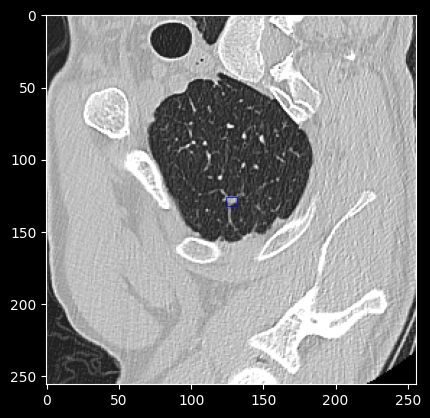

In [10]:
bbox = val_dataset[0]["bbox"][0]
# x0, y0, x1, y1 = 93, 47, 102, 57
# x0, y0, x1, y1 = 80, 70, 95, 87
# x0, y0, x1, y1 = 85, 10, 95, 25
# bbox = torch.Tensor((y0, x0, y1, x1))
plt.imshow(imgs[0, 0, ...] / 255, "gray")
show_box(bbox, plt.gca())
plt.show()
    
    

In [13]:
box_torch = bbox * 4
box_torch = box_torch[None, :]
sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
medsam_seg_prob, _= sam_model.mask_decoder(
    image_embeddings=image_embeddings, # (B, 256, 64, 64)
    image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
    dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
    multimask_output=False,
)
# ori_res_masks = F.interpolate(
#         medsam_seg_prob,
#         size=(128, 128),
#         mode="bilinear",
#         align_corners=False,
#         )
# convert soft mask to hard mask
ori_res_masks = torch.sigmoid(medsam_seg_prob)    
med_seg = ori_res_masks > 0.5
img_arr4 = med_seg.squeeze().cpu().numpy().astype(float)

[0.         0.12914285 0.12971428 ... 0.99885714 0.9994286  1.        ]


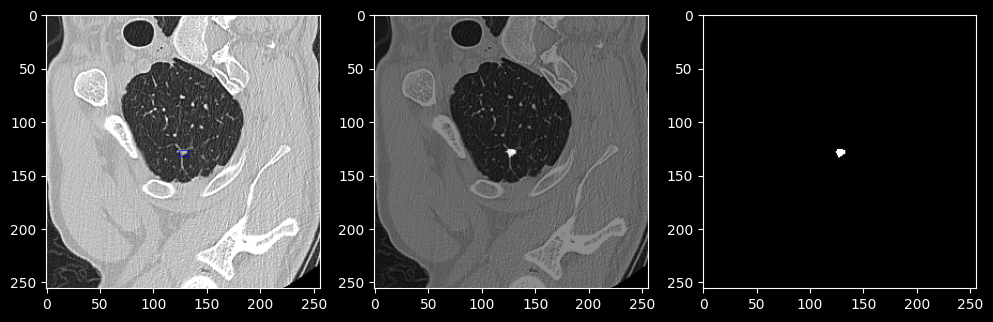

In [14]:
plt.figure(figsize=(12, 8))
print(np.unique(imgs[0, 0, ...]))
plt.subplot(131).imshow(imgs[0, 0, ...], "gray")
ax = plt.subplot(131)
show_box(bbox, ax)
plt.subplot(132).imshow(imgs[0, 0, ...] + img_arr4, "gray")
plt.subplot(133).imshow(img_arr4, "gray")
plt.show()